# [GN-1]네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

In [1]:
import os
import tensorflow as tf

# GPU 성능을 위해 세팅
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# 1.Data load

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

len(train_data)

150000

## 1-2 전처리

In [4]:

train_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
train_data = train_data.dropna(how = 'any')  # NA제거
train_data['document'] = train_data['document'].str.replace(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]"," ",regex=True) # 특수문자 제거 - Regex


test_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
test_data = test_data.dropna(how = 'any')  # NA제거
test_data['document'] = test_data['document'].str.replace(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]"," ",regex=True) # 특수문자 제거 - Regex



# 2.사전 만들기

## 2.1 Copus Raw 데이타 분석

In [5]:
# 사전을 만들 copus raw를 담아두자. 
raw = train_data['document']
print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Example:
>> 아 더빙   진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯  그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐  시작하고 3분만에 나왔다  리플릿 사진 보며 불안하더니만  


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


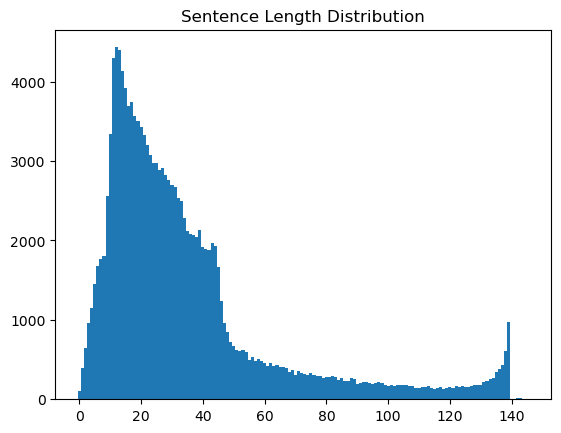

In [6]:
# 데이타 분석
min_len = 999
max_len = 0
sum_len = 0

for  sen in raw:
    length = len(sen)
    
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

- 문장의 평균길이가 35인데 제일 긴 문장이 146이다. 


In [7]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for idx, sen in raw.items():
        if len(str(sen)) == length:
            print(sen)
            count += 1
            if count > 100: return

In [8]:
check_sentence_with_length(raw, 146)

 스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만  이건 그냥 비현실적인 자동차만    독일3사 슈퍼카 홍보 프로그램도 아니구 대중적인 자동차 방송으로 이루어 졌으면 합니다  보는내내   카탈로그 책자  를   동영상으로 보여주는 방송   같아서 씁쓸하네요   
   니 짓은 생각않고  웬 복수   의 교훈이라  그럼   서바이벌 액션  으로 홍보하면 안되지  초반 45분은 멋지게 열더니   억지 반전  하드고어로 시간끌다가  허둥지둥 화해로 끝내버리네  90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화   
 2007 02 25  벌교의 한 국밥집  점심    갸는 첫째고  저 놈은 우리 둘째    재문    아줌마  미안해  그냥   아줌마  나 그 남방 잘 어울려ㅠ ㅠ    대식에게 복수하려던 1주일 전  대식의 엄마를 먼저 만났다  사랑의 꽃남방도     o 


In [9]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 4000을 초과하는 문장 길이를 추출합니다.
    if _sum > 4000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15


In [10]:
# 이상치 체크
check_sentence_with_length(raw, 12)

아햏햏 아햏햏 아햏햏 
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음  
무술인이 왜 총을드나 
너무너무 훈훈하네요  
현실은 꿈  꿈은 현실
답없네  뭐하는건지  
엔딩이 넘 슬퍼요   
감동감동감동의 도가니탕
정말 최고의 영화   
진짜 짜증나는 영화  
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다 
정말 광해와 비슷한가 
더빙이 똥이야     
잠을 청할 수 있었다 
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다   지루해  
사과해요  나한테   
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화  
기적은 이미 일어났다 
답을 알려고 하지마라 
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐 
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱  
막장드라마가 따로없구만
말 필요엄따    진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ 차븟ㅇㄱ디시
순수하고 아름답다   
변태적 성욕 자기합리화
흠    나름 갠찬네요
걍 10점 이라길래  
실력이 필요없는 상황 
감동과 웃음을 한방에 
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다   참
평점알바들을 위해 1점
볼만합니다 강추  ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다        
2 3  10자 제한 
아무도 안달았네  ㄷㄷ
엉성하고 어설프고   
그냥 보통으로 보았다 
너무 슬픈영화  울음ㅠ
으리는 개뿔 ㅡ  ㅡ 
처음 본 에로 영화  
평점 조정을 위해   
그냥 쓰레기지 쓰레기 
쵝오네요 최고 대박영화
유전무죄 무전유죄   
의외의 꿀잼 이였습니다
어차피 우승은 송민호 
이 때부터가 쓰레기였지
완전 찝찝한 영화   
이상형이 바뀌었습니다 
역시 산드라블록 누님 
결국 엄마가 죽인거네 
그냥 그저 별시리   
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음   
역시 재미있군요  ㅁ 
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다  참 재미없다 

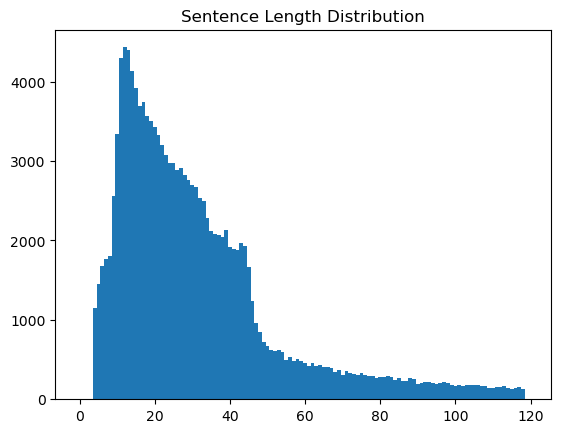

In [11]:
max_len = 120
min_len = 5

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in raw if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


## 2.2 SentencePiece 모델 훈련

In [12]:
import sentencepiece as spm
import os
temp_file = './data/sp_tokenizer/naver_review_sp.temp'


with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

templates= '--input={} \
--pad_id={} \
--bos_id={} \
--eos_id={} \
--unk_id={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={}'

train_input_file = temp_file
pad_id=0  #<pad> token을 0으로 설정

prefix = 'naver_review_spm' # 저장될 tokenizer 모델에 붙는 이름
bos_id=1 #<start> token을 1으로 설정
eos_id=2 #<end> token을 2으로 설정
unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 

prefix = 'naver_review_spm' # 저장될 tokenizer 모델에 붙는 이름
vocab_size = 8000 # vocab 사이즈
model_type ='unigram' # Choose from unigram (default), bpe, char, or word

cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)

spm.SentencePieceTrainer.Train(cmd)

In [13]:
s = spm.SentencePieceProcessor()
s.Load('naver_review_spm.model')

s.SetEncodeExtraOptions('bos:eos')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0.5))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1, 1364, 8, 384, 13, 1391, 8, 130, 14, 3, 2]
['<s>', '▁아버지', '가', '방', '에', '들', '어', '가', '신', '다', '.', '</s>']
아버지가방에들어가신다 ⁇ 


# 3.토큰화

## 3.1 sp_tokenize 함수

In [14]:
def sp_tokenize(s, corpus):

    seq_list = []
    
    for sen in corpus:
        seq_list.append(s.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    return seq_list, word_index, index_word

In [15]:
# sp_tokenize 테스트 점검
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1, 543, 2866, 11, 1108, 2014, 3, 2], [1, 1221, 2247, 173, 542, 8, 4, 12, 7480, 940, 3, 2]]


In [16]:
print(index_word[2866])

▁밥


In [17]:
print(word_index['▁밥'])

2866


In [18]:
tokensIDs = s.EncodeAsIds('보면서 웃지 않는 건 불가능하다')
tokensIDs

[1, 606, 630, 16, 538, 530, 5493, 79, 2]

In [19]:
s.DecodeIds(tokensIDs)

'보면서 웃지 않는 건 불가능하다'

## 3.2 데이터 셋 준비

In [20]:
# 데이타 셋 준비
X_train, word_index, index_word = sp_tokenize(s, train_data['document'] )
y_train =  np.array(list(train_data['label']))
X_test, _ , _ = sp_tokenize(s,test_data['document'] )
y_test =  np.array(list(test_data['label']))

In [21]:
len(X_train), len(y_train), len(X_test), len(y_test)

(146182, 146182, 49157, 49157)

In [22]:
for i in range(3):
    label = y_train[i]
    encode = X_train[i]
    decode = s.DecodeIds(encode)
    print(f'label: {label}\n\
        encode:{encode}\n\
        decode:{decode}')

label: 0
        encode:[1, 46, 794, 26, 1832, 51, 1286, 2]
        decode:아 더빙 진짜 짜증나네요 목소리
label: 1
        encode:[1, 1446, 992, 154, 1306, 27, 219, 2668, 380, 1380, 6113, 707, 365, 2]
        decode:흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
label: 0
        encode:[1, 18, 421, 6891, 308, 2512, 42, 465, 2078, 2437, 283, 2]
        decode:너무재밓었다그래서보는것을추천한다


In [23]:
X_test[0]

[1, 2579, 160, 2]

# 4.Embedding 처리

In [24]:
# Embedding 테스트
vocab_size = len(word_index)  # 8000
word_vector_dim = 100    # 그림과 같이 100차원의 워드 벡터를 가정합니다.
maxlen = 30

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                    value=word_index["<pad>"],
                                                    padding='post', # 혹은 'pre'
                                                    maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_index["<pad>"],
                                                    padding='post', # 혹은 'pre'
                                                    maxlen=maxlen)

output  = embedding(X_train)

In [25]:
output[0]

<tf.Tensor: shape=(30, 100), dtype=float32, numpy=
array([[ 0.01353874, -0.03496393, -0.03462083, ...,  0.00015463,
         0.0007842 , -0.01644596],
       [ 0.01945918, -0.03854777,  0.04634423, ..., -0.04907569,
        -0.03525738, -0.0090315 ],
       [-0.00696963, -0.04411605, -0.03452419, ..., -0.02470088,
        -0.01507866,  0.04383076],
       ...,
       [ 0.02455217,  0.04127479, -0.0254838 , ...,  0.04190004,
        -0.01646918, -0.04264551],
       [ 0.02455217,  0.04127479, -0.0254838 , ...,  0.04190004,
        -0.01646918, -0.04264551],
       [ 0.02455217,  0.04127479, -0.0254838 , ...,  0.04190004,
        -0.01646918, -0.04264551]], dtype=float32)>

In [26]:
encode = X_train[0]
encode

array([   1,   46,  794,   26, 1832,   51, 1286,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [27]:
for i in range(3):
    label = y_train[i]
    encode = X_train[i]
    decode = s.DecodeIds(encode.tolist())
    print(f'label: {label}\n\
        encode:{encode}\n\
        decode:{decode}')

label: 0
        encode:[   1   46  794   26 1832   51 1286    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
        decode:아 더빙 진짜 짜증나네요 목소리
label: 1
        encode:[   1 1446  992  154 1306   27  219 2668  380 1380 6113  707  365    2
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
        decode:흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
label: 0
        encode:[   1   18  421 6891  308 2512   42  465 2078 2437  283    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
        decode:너무재밓었다그래서보는것을추천한다


# 5.LSTM모델 구성하기


In [28]:

from sklearn.model_selection import train_test_split

partial_X_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [29]:
# 모델 구성
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import regularizers
from keras.layers import Dropout

vocab_size = len(word_index) 
word_vector_dim = 100  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    input_shape=(None,)
                                    ))
model.add(Bidirectional(tf.keras.layers.LSTM(32)))  
model.add(Dropout(0.2))  
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         800000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 834,577
Trainable params: 834,577
Non-trainable params: 0
__________________________________________________

In [30]:
# 훈련개시
def model_training(model, epochs):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience = 2
        )
    ]
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
                    
    epochs=epochs  

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        callbacks = callbacks,
                        verbose=1)
    return history

history = model_training(model,20)

Epoch 1/20
229/229 [==============================] - 8s 15ms/step - loss: 0.4566 - accuracy: 0.7801 - val_loss: 0.3608 - val_accuracy: 0.8436
Epoch 2/20
229/229 [==============================] - 3s 12ms/step - loss: 0.3340 - accuracy: 0.8563 - val_loss: 0.3484 - val_accuracy: 0.8444
Epoch 3/20
229/229 [==============================] - 3s 12ms/step - loss: 0.3085 - accuracy: 0.8647 - val_loss: 0.3482 - val_accuracy: 0.8449
Epoch 4/20
229/229 [==============================] - 3s 12ms/step - loss: 0.2891 - accuracy: 0.8699 - val_loss: 0.3590 - val_accuracy: 0.8445
Epoch 5/20
229/229 [==============================] - 3s 12ms/step - loss: 0.2702 - accuracy: 0.8772 - val_loss: 0.3662 - val_accuracy: 0.8455
Epoch 6/20
229/229 [==============================] - 3s 12ms/step - loss: 0.2529 - accuracy: 0.8843 - val_loss: 0.3740 - val_accuracy: 0.8407
Epoch 7/20
229/229 [==============================] - 3s 12ms/step - loss: 0.2351 - accuracy: 0.8908 - val_loss: 0.4001 - val_accuracy: 0.8423

In [31]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 6s - loss: 0.4101 - accuracy: 0.8402 - 6s/epoch - 4ms/step
[0.4101373255252838, 0.8402058482170105]


📝 Test Data Set에 대한 Accuracy 84% 

In [33]:
import matplotlib.pyplot as plt
def display_history(history, type = 'loss'):
    plt.figure(figsize=(8,4))
    history_dict = history.history
    acc = history_dict['accuracy']
    epochs = range(1, len(acc) + 1)   
    
    if type == 'loss':
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        plt.plot(epochs, loss, 'b--', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
    elif type == 'accuracy':
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        plt.plot(epochs, acc, 'b--', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.ylabel('accuracy')
        
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


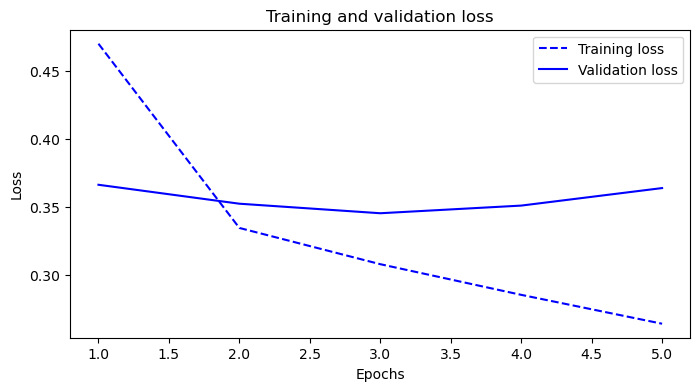

In [99]:
display_history(history,'loss')

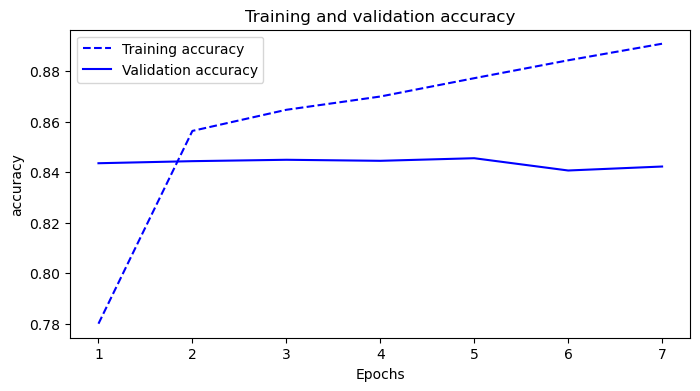

In [34]:
display_history(history,'accuracy')

# 6.SentencePiece 성능평가

SentencePicec 평가 기준

- Model Type: unigram vs bpe
- Vocab size: 8k vs 16k
- word vector dim: 100 vs 200 

In [35]:
# 사전 만들기

def make_vocab(vocab_size=8000, model_type='unigram' ):
    with open(temp_file, 'w') as f:
        for row in filtered_corpus:  
            f.write(str(row) + '\n')

    model_prefix = 'naver_review_spm' +'_'+str(vocab_size)+'_' + model_type
    spm.SentencePieceTrainer.Train( '--input={} --model_prefix={} --model_type={} --vocab_size={}'.format(temp_file,model_prefix,model_type, vocab_size))



In [36]:
make_vocab(8000,'unigram')
make_vocab(16000,'unigram')
make_vocab(8000,'bpe')
make_vocab(16000,'bpe')


📝 아래와 같이 파일이 생성된다   
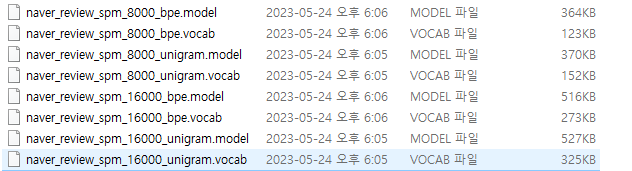

In [37]:
def model_training_perf(model,X_train, y_train, X_val, y_val, epochs):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience = 2
        )
    ]
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
                    
    epochs=epochs  

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        callbacks = callbacks,
                        verbose=1)
    return history

In [38]:
def sp_tokenize_perf(sp_model, corpus,vocab_file):

    seq_list = []
    
    for sen in corpus:
        seq_list.append(sp_model.EncodeAsIds(sen))

    with open("./{}.vocab".format(vocab_file), 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    return seq_list, word_index, index_word

In [39]:

def spm_performance_test(sp_model,vector_dim):
    
    s = spm.SentencePieceProcessor()
    s.Load('{}.model'.format(sp_model))
    s.SetEncodeExtraOptions('bos:eos')
    
    X_train_data, word_index_p, index_word_p = sp_tokenize_perf(s, train_data['document'], sp_model)
    y_train_data =  np.array(list(train_data['label']))
    X_test, _ , _ = sp_tokenize_perf(s,test_data['document'], sp_model )
    y_test =  np.array(list(test_data['label']))
    
    
    vocab_size_ = len(word_index_p)  
    word_vector_dim_ = vector_dim    
    maxlen = 30
   
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train_data,
                                                        value=0,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=0,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)
    
    partial_X_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train_data, test_size=0.2)


    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size_, 
                                        word_vector_dim_, 
                                        input_shape=(None,)
                                        ))
    model.add(Bidirectional(tf.keras.layers.LSTM(32)))  
    model.add(Dropout(0.2))  
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    history = model_training_perf(model,partial_X_train, partial_y_train, x_val, y_val,10)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(results)
    return history, results
    

## 6.1 Unigram Type

In [40]:
hist_8k_unigram_dim100, results=spm_performance_test('naver_review_spm_8000_unigram',100)

Epoch 1/10
229/229 [==============================] - 6s 14ms/step - loss: 0.4593 - accuracy: 0.7761 - val_loss: 0.3590 - val_accuracy: 0.8429
Epoch 2/10
229/229 [==============================] - 3s 12ms/step - loss: 0.3284 - accuracy: 0.8595 - val_loss: 0.3500 - val_accuracy: 0.8468
Epoch 3/10
229/229 [==============================] - 3s 12ms/step - loss: 0.2997 - accuracy: 0.8715 - val_loss: 0.3451 - val_accuracy: 0.8480
Epoch 4/10
229/229 [==============================] - 3s 11ms/step - loss: 0.2748 - accuracy: 0.8814 - val_loss: 0.3537 - val_accuracy: 0.8450
Epoch 5/10
229/229 [==============================] - 3s 12ms/step - loss: 0.2537 - accuracy: 0.8896 - val_loss: 0.3756 - val_accuracy: 0.8454
1537/1537 - 6s - loss: 0.3827 - accuracy: 0.8429 - 6s/epoch - 4ms/step
[0.3827314078807831, 0.8428504467010498]


In [41]:
data = {'col': ['8k_unigram_dim100'],'type': ['unigram'],'vacab_size': ['8k'],'dim': [100], 'loss': [results[0]], 'accuracy': [results[1]]}
results_df = pd.DataFrame(data)

In [42]:
results_df

,col,type,vacab_size,dim,loss,accuracy
0,8k_unigram_dim100,unigram,8k,100,0.382731,0.84285


In [43]:
hist_8k_unigram_dim200, results=spm_performance_test('naver_review_spm_8000_unigram',200)

Epoch 1/10
229/229 [==============================] - 6s 16ms/step - loss: 0.4405 - accuracy: 0.7915 - val_loss: 0.3606 - val_accuracy: 0.8409
Epoch 2/10
229/229 [==============================] - 3s 13ms/step - loss: 0.3266 - accuracy: 0.8596 - val_loss: 0.3446 - val_accuracy: 0.8445
Epoch 3/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2980 - accuracy: 0.8698 - val_loss: 0.3501 - val_accuracy: 0.8450
Epoch 4/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2728 - accuracy: 0.8810 - val_loss: 0.3596 - val_accuracy: 0.8472
Epoch 5/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2457 - accuracy: 0.8924 - val_loss: 0.3746 - val_accuracy: 0.8434
Epoch 6/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2190 - accuracy: 0.9048 - val_loss: 0.4199 - val_accuracy: 0.8380
1537/1537 - 6s - loss: 0.4183 - accuracy: 0.8405 - 6s/epoch - 4ms/step
[0.4183105230331421, 0.8405110239982605]


In [44]:
results_df.loc[len(results_df)] = ['8k_unigram_dim200', 'unigram', '8k', '200', results[0], results[1]]

In [46]:
hist_16k_unigram_dim100, results = spm_performance_test('naver_review_spm_16000_unigram',100)

Epoch 1/10
229/229 [==============================] - 6s 16ms/step - loss: 0.4487 - accuracy: 0.7844 - val_loss: 0.3523 - val_accuracy: 0.8454
Epoch 2/10
229/229 [==============================] - 3s 12ms/step - loss: 0.3033 - accuracy: 0.8727 - val_loss: 0.3570 - val_accuracy: 0.8443
Epoch 3/10
229/229 [==============================] - 3s 12ms/step - loss: 0.2639 - accuracy: 0.8884 - val_loss: 0.3658 - val_accuracy: 0.8467
Epoch 4/10
229/229 [==============================] - 3s 12ms/step - loss: 0.2269 - accuracy: 0.9026 - val_loss: 0.4038 - val_accuracy: 0.8415
Epoch 5/10
229/229 [==============================] - 3s 12ms/step - loss: 0.1939 - accuracy: 0.9146 - val_loss: 0.4479 - val_accuracy: 0.8425
1537/1537 - 6s - loss: 0.4444 - accuracy: 0.8402 - 6s/epoch - 4ms/step
[0.4443567097187042, 0.8402465581893921]


In [47]:
results_df.loc[len(results_df)] = ['16k_unigram_dim100', 'unigram', '16k', '100', results[0], results[1]]

In [48]:
hist_16k_unigram_dim200, results = spm_performance_test('naver_review_spm_16000_unigram',200)

Epoch 1/10
229/229 [==============================] - 6s 17ms/step - loss: 0.4362 - accuracy: 0.7916 - val_loss: 0.3530 - val_accuracy: 0.8431
Epoch 2/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2982 - accuracy: 0.8743 - val_loss: 0.3489 - val_accuracy: 0.8459
Epoch 3/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2552 - accuracy: 0.8924 - val_loss: 0.3632 - val_accuracy: 0.8444
Epoch 4/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2129 - accuracy: 0.9091 - val_loss: 0.4067 - val_accuracy: 0.8439
1537/1537 - 6s - loss: 0.3997 - accuracy: 0.8450 - 6s/epoch - 4ms/step
[0.39965203404426575, 0.8450474739074707]


In [49]:
results_df.loc[len(results_df)] = ['16k_unigram_dim200', 'unigram', '16k', '200', results[0], results[1]]

## 6.2 BPE type

In [51]:
hist_8k_bpe_dim100,results =spm_performance_test('naver_review_spm_8000_bpe',100)
results_df.loc[len(results_df)] = ['8k_bpe_dim100', 'bpe', '8k', '100', results[0], results[1]]

Epoch 1/10
229/229 [==============================] - 6s 14ms/step - loss: 0.4687 - accuracy: 0.7709 - val_loss: 0.3683 - val_accuracy: 0.8388
Epoch 2/10
229/229 [==============================] - 3s 12ms/step - loss: 0.3310 - accuracy: 0.8589 - val_loss: 0.3502 - val_accuracy: 0.8476
Epoch 3/10
229/229 [==============================] - 3s 11ms/step - loss: 0.3027 - accuracy: 0.8697 - val_loss: 0.3543 - val_accuracy: 0.8463
Epoch 4/10
229/229 [==============================] - 3s 11ms/step - loss: 0.2760 - accuracy: 0.8802 - val_loss: 0.3719 - val_accuracy: 0.8428
1537/1537 - 6s - loss: 0.3666 - accuracy: 0.8449 - 6s/epoch - 4ms/step
[0.3666498363018036, 0.8449254631996155]


In [52]:
hist_8k_bpe_dim200, results=spm_performance_test('naver_review_spm_8000_bpe',200)
results_df.loc[len(results_df)] = ['8k_bpe_dim200', 'bpe', '8k', '200', results[0], results[1]]

Epoch 1/10
229/229 [==============================] - 6s 17ms/step - loss: 0.4396 - accuracy: 0.7908 - val_loss: 0.3541 - val_accuracy: 0.8445
Epoch 2/10
229/229 [==============================] - 3s 13ms/step - loss: 0.3244 - accuracy: 0.8591 - val_loss: 0.3435 - val_accuracy: 0.8495
Epoch 3/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2945 - accuracy: 0.8711 - val_loss: 0.3463 - val_accuracy: 0.8506
Epoch 4/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2687 - accuracy: 0.8806 - val_loss: 0.3713 - val_accuracy: 0.8479
Epoch 5/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2441 - accuracy: 0.8907 - val_loss: 0.3769 - val_accuracy: 0.8474
1537/1537 - 6s - loss: 0.3803 - accuracy: 0.8450 - 6s/epoch - 4ms/step
[0.38030070066452026, 0.8450271487236023]


In [53]:
hist_16k_bpe_dim100, results=spm_performance_test('naver_review_spm_16000_bpe',100)
results_df.loc[len(results_df)] = ['16k_bpe_dim100', 'bpe', '8k', '100', results[0], results[1]]

Epoch 1/10
229/229 [==============================] - 6s 15ms/step - loss: 0.4466 - accuracy: 0.7910 - val_loss: 0.3527 - val_accuracy: 0.8466
Epoch 2/10
229/229 [==============================] - 3s 12ms/step - loss: 0.3021 - accuracy: 0.8720 - val_loss: 0.3513 - val_accuracy: 0.8460
Epoch 3/10
229/229 [==============================] - 3s 12ms/step - loss: 0.2589 - accuracy: 0.8899 - val_loss: 0.3697 - val_accuracy: 0.8477
Epoch 4/10
229/229 [==============================] - 3s 12ms/step - loss: 0.2177 - accuracy: 0.9065 - val_loss: 0.4187 - val_accuracy: 0.8398
Epoch 5/10
229/229 [==============================] - 3s 12ms/step - loss: 0.1830 - accuracy: 0.9192 - val_loss: 0.4578 - val_accuracy: 0.8308
1537/1537 - 6s - loss: 0.4419 - accuracy: 0.8338 - 6s/epoch - 4ms/step
[0.44188690185546875, 0.833797812461853]


In [54]:
hist_16k_bpe_dim200, results=spm_performance_test('naver_review_spm_16000_bpe',200)
results_df.loc[len(results_df)] = ['16k_bpe_dim200', 'bpe', '8k', '200', results[0], results[1]]

Epoch 1/10
229/229 [==============================] - 7s 17ms/step - loss: 0.4431 - accuracy: 0.7935 - val_loss: 0.3546 - val_accuracy: 0.8461
Epoch 2/10
229/229 [==============================] - 3s 15ms/step - loss: 0.3071 - accuracy: 0.8711 - val_loss: 0.3471 - val_accuracy: 0.8473
Epoch 3/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2643 - accuracy: 0.8898 - val_loss: 0.3592 - val_accuracy: 0.8492
Epoch 4/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2255 - accuracy: 0.9069 - val_loss: 0.3977 - val_accuracy: 0.8454
Epoch 5/10
229/229 [==============================] - 3s 14ms/step - loss: 0.1899 - accuracy: 0.9217 - val_loss: 0.4423 - val_accuracy: 0.8413
1537/1537 - 6s - loss: 0.4368 - accuracy: 0.8424 - 6s/epoch - 4ms/step
[0.436791330575943, 0.8423622250556946]


### 훈련 결과 데이타
- hist_8k_unigram_dim100
- hist_8k_uniform_dim200
- hist_16k_uniform_dim100
- hist_16k_uniform_dim200

- hist_8k_bpe_dim100
- hist_8k_bpe_dim200
- hist_16k_bpe_dim100
- hist_16k_bpe_dim200

In [55]:
results_df

,col,type,vacab_size,dim,loss,accuracy
0,8k_unigram_dim100,unigram,8k,100,0.382731,0.842850
1,8k_unigram_dim200,unigram,8k,200,0.418311,0.840511
2,16k_unigram_dim100,unigram,16k,100,0.444357,0.840247
3,16k_unigram_dim200,unigram,16k,200,0.399652,0.845047
4,8k_bpe_dim100,bpe,8k,100,0.366650,0.844925
5,8k_bpe_dim200,bpe,8k,200,0.380301,0.845027
6,16k_bpe_dim100,bpe,8k,100,0.441887,0.833798
7,16k_bpe_dim200,bpe,8k,200,0.436791,0.842362


## 6.3 Word_vector_dim 100 vs 200 성능 비교

In [56]:
def performance_100_vs_200(val='val_accuracy',loc='lower left'):
    # 100 vs 200 accuracy
    fig, ax = plt.subplots(2,2,figsize = (8,5))
    fig.suptitle('100 vs 200  '+ val, fontsize=16)

    plt.subplot(2,2,1)
    plt.plot(hist_8k_unigram_dim100.history[val])
    plt.plot(hist_8k_unigram_dim200.history[val])
    plt.ylabel(val)
    plt.title('8k_unigram 100 vs 200')
    plt.legend(['100','200'], loc=loc)

    plt.subplot(2,2,2)
    plt.plot(hist_16k_unigram_dim100.history[val])
    plt.plot(hist_16k_unigram_dim200.history[val])
    plt.title('16k_unigram 100 vs 200')
    plt.legend(['100','200'], loc=loc)

    plt.subplot(2,2,3)
    plt.plot(hist_8k_bpe_dim100.history[val])
    plt.plot(hist_8k_bpe_dim200.history[val])
    plt.ylabel(val)
    plt.xlabel('epoch')
    plt.title('8k_bpe 100 vs 200')
    plt.legend(['100','200'], loc=loc)

    plt.subplot(2,2,4)
    plt.plot(hist_16k_bpe_dim100.history[val])
    plt.plot(hist_16k_bpe_dim200.history[val])
    plt.xlabel('epoch')
    plt.title('16k_bpe 100 vs 200')
    plt.legend(['100','200'], loc=loc)

    plt.tight_layout()
    plt.show() 

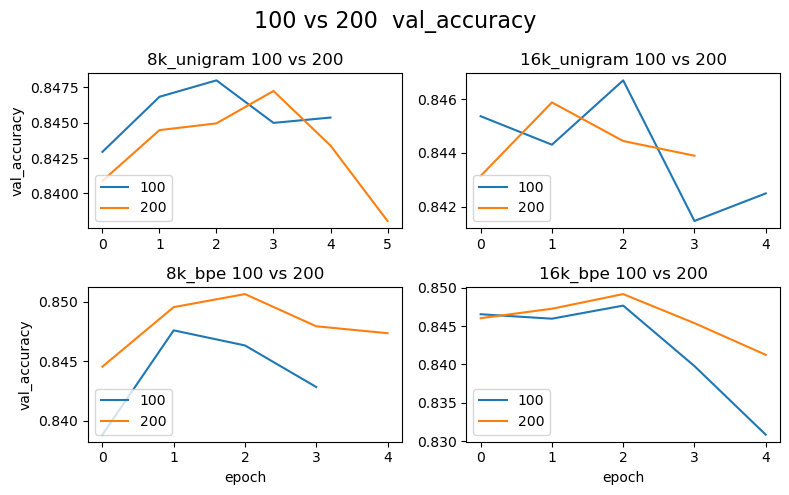

In [57]:
performance_100_vs_200(val='val_accuracy',loc='lower left')


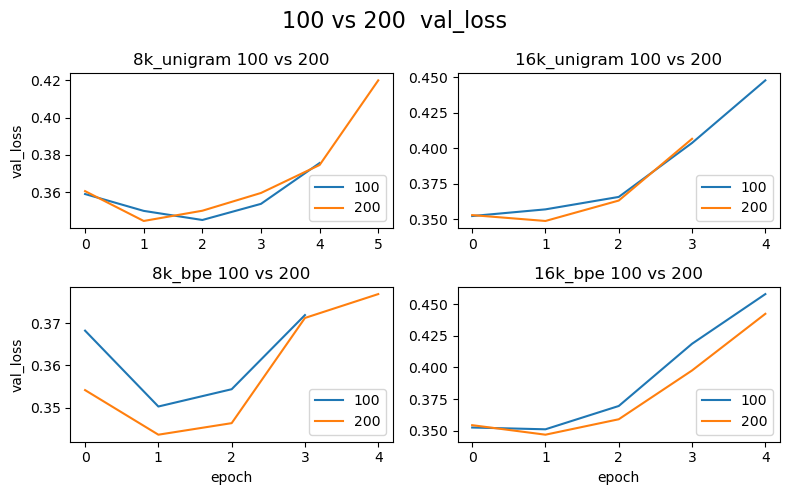

In [58]:
performance_100_vs_200(val='val_loss',loc='lower right')

📝 Empadding word vector dimension에 대한 성능을 비교해보니, 과적합이 일어나기 전인 epoch 1 ~2전후로 200이 accuracy에서 높고,    
loss에서도 낮게 보여져서 100보다는 `200`이 더 나은 성능이라 할 수 있다.   
- test data 평가결과   
<img src='https://user-images.githubusercontent.com/95423215/240873767-f30960ad-6b8e-41fa-b6fa-9eb591ea4709.png'>

## 6.4 Unigram vs BPE model 성능 비교

In [59]:
def performance_unigram_vs_bpe(val='val_accuracy',loc='lower left'):
    fig, ax = plt.subplots(2,2,figsize = (8,5))
    fig.suptitle('unigram vs bpe  '+ val, fontsize=16)

    plt.subplot(2,2,1)
    plt.plot(hist_8k_unigram_dim100.history[val])
    plt.plot(hist_8k_bpe_dim100.history[val])
    plt.ylabel(val)
    plt.title('8k_100 unigram vs bpe')
    plt.legend(['unigram','bpe'], loc=loc)

    plt.subplot(2,2,2)
    plt.plot(hist_16k_unigram_dim100.history[val])
    plt.plot(hist_16k_bpe_dim100.history[val])
    plt.title('16k_100 unigram vs bpe')
    plt.legend(['unigram','bpe'], loc=loc)

    plt.subplot(2,2,3)
    plt.plot(hist_8k_unigram_dim200.history[val])
    plt.plot(hist_8k_bpe_dim200.history[val])
    plt.ylabel(val)
    plt.xlabel('epoch')
    plt.title('8k_200 unigram vs bpe')
    plt.legend(['unigram','bpe'], loc=loc)

    plt.subplot(2,2,4)
    plt.plot(hist_16k_unigram_dim200.history[val])
    plt.plot(hist_16k_bpe_dim200.history[val])
    plt.xlabel('epoch')
    plt.title('16k_200 unigram vs bpe')
    plt.legend(['unigram','bpe'], loc=loc)

    plt.tight_layout()
    plt.show()

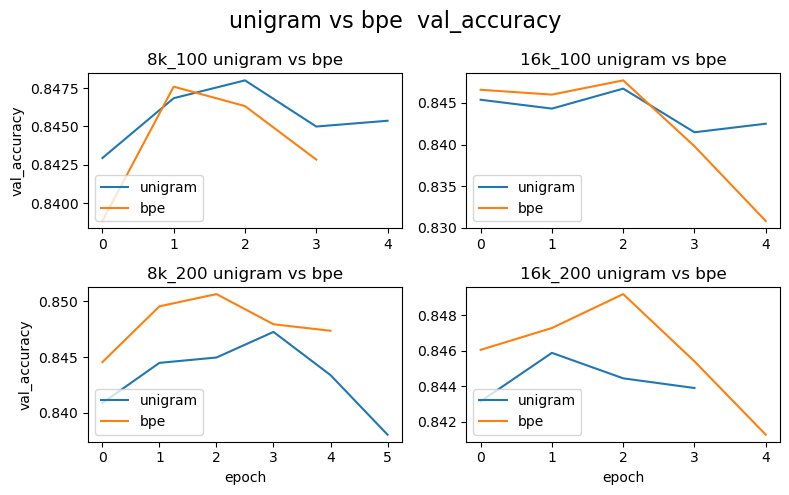

In [60]:
performance_unigram_vs_bpe('val_accuracy','lower left' )

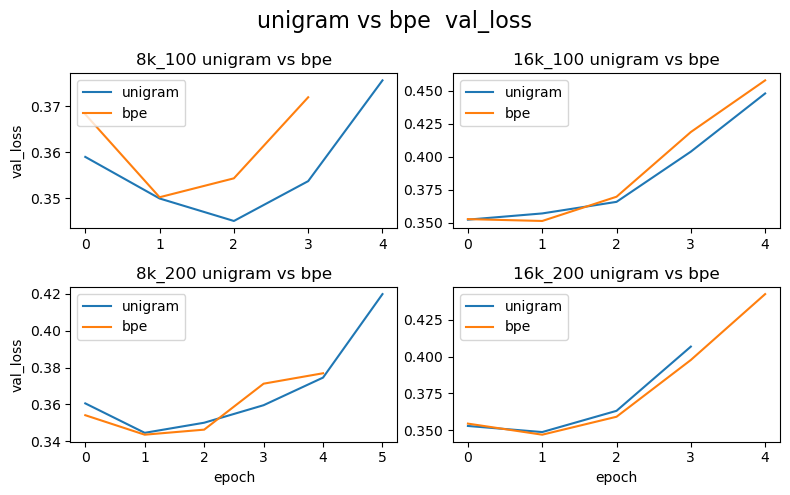

In [61]:
performance_unigram_vs_bpe('val_loss','upper left' )

📝 unigram와 bpe 성능 비교 결과 훈련중 데이터도 Test 데이타에서도 뚜렷하게 어느 것이 차이나게 좋은 성능이라 결론 내리기 어렵다.
- Test 데이타 평가결과      
<img src='https://user-images.githubusercontent.com/95423215/240873795-11d6dcd7-3f9e-4485-bd7b-ec48de576822.png'>


## 6.5 Vocab Size 8K vs 16K

In [62]:
def performance_8k_vs_16k(val='val_accuracy',loc='lower left'):
    fig, ax = plt.subplots(2,2,figsize = (8,5))
    fig.suptitle('8K vs 16K  '+ val, fontsize=16)

    plt.subplot(2,2,1)
    plt.plot(hist_8k_unigram_dim100.history[val])
    plt.plot(hist_16k_unigram_dim100.history[val])
    plt.ylabel(val)
    plt.title('unigram_100 8k vs 16k')
    plt.legend(['8k','16k'], loc=loc)

    plt.subplot(2,2,2)
    plt.plot(hist_8k_unigram_dim200.history[val])
    plt.plot(hist_16k_unigram_dim200.history[val])
    plt.title('unigram_200 8k vs 16k')
    plt.legend(['8k','16k'], loc=loc)

    plt.subplot(2,2,3)
    plt.plot(hist_8k_bpe_dim100.history[val])
    plt.plot(hist_16k_bpe_dim100.history[val])
    plt.ylabel(val)
    plt.xlabel('epoch')
    plt.title('bpe_100 8k vs 16k')
    plt.legend(['8k','16k'], loc=loc)

    plt.subplot(2,2,4)
    plt.plot(hist_8k_bpe_dim200.history[val])
    plt.plot(hist_16k_bpe_dim200.history[val])
    plt.xlabel('epoch')
    plt.title('bpe_200 8k vs 16k')
    plt.legend(['8k','16k'], loc=loc)

    plt.tight_layout()
    plt.show()

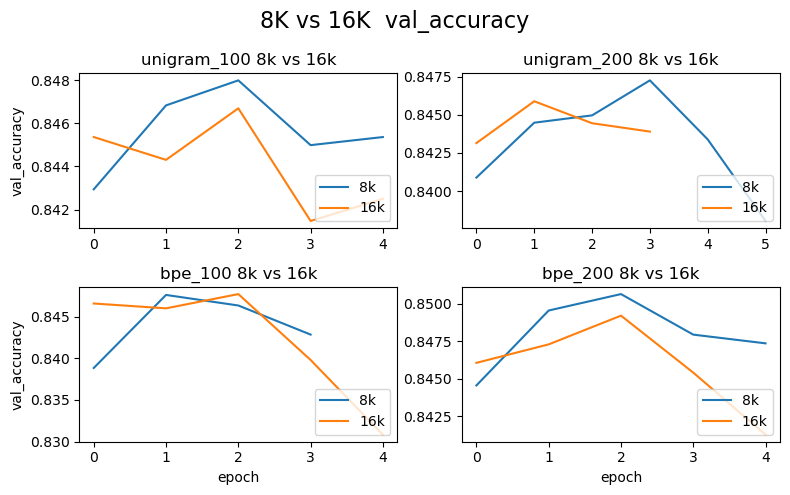

In [63]:
performance_8k_vs_16k(val='val_accuracy',loc='lower right')

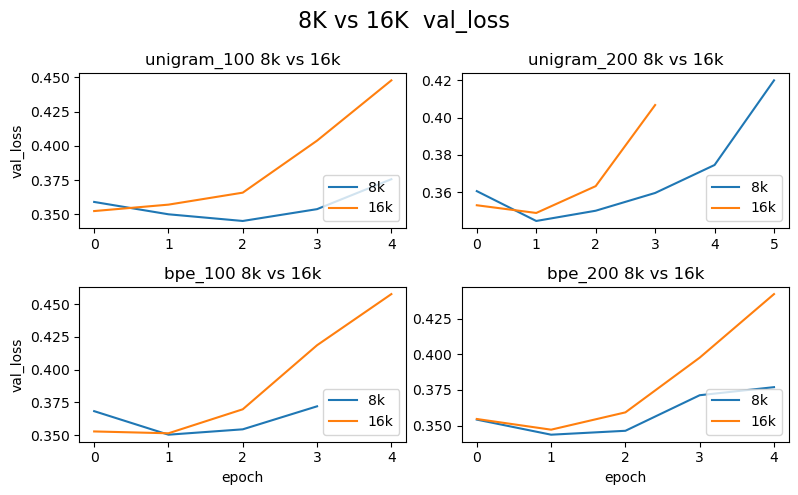

In [64]:
performance_8k_vs_16k(val='val_loss',loc='lower right')

📝8K와 16K 성능 비교 결과 훈련중 데이터도 Test 데이타에서도 뚜렷하게 어느 것이 차이나게 좋은 성능이라 결론 내리기 어렵다.
- Text 데이타 평가 결과   
<img src='https://user-images.githubusercontent.com/95423215/240873813-18756728-1a8d-4551-97e5-882837894a5d.png'>

# 7.SP vs Mecab vs OKT 형태소 분석기 비교

https://github.com/billygogo/Aiffel_GD_NLP/blob/main/%5BGN_1%5DSP_Mecab_OKT.ipynb

# 8.회고

- SentencePiece를 사용해서 사전만들기를 처음해보았다. 
- 사전을 만드는 단계와 tokenize에 대한 과정을 상세하게 이해하고 구현할 수 있었다. 
- SentencePiece 옵션을 어려가지 바꿔가면서 더 나은 성능을 기대했는데, 뚜렷하게 확연한 차이를 느끼지는 못했다. 

### 참고자료

https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb